# Toy Diffusion Model (DDPM) — "Hello World" on 2D Ring of Gaussians

This notebook implements a minimal **DDPM (Denoising Diffusion Probabilistic Model)** from scratch on a simple 2D dataset (8-Gaussians arranged on a circle).  

Structure:
1. Imports & Config  
2. Dataset (Mixture of Gaussians)  
3. Diffusion Schedule  
4. Score Model (MLP)  
5. Training (Noise Prediction)  
6. Sampling (Reverse Diffusion)  
7. Run & Visualise

No tricks, no libraries — just raw PyTorch.


In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'mps'
torch.manual_seed(0)


### Dataset — Mixture of Gaussians on a Circle

We use the same toy dataset as in flow matching: **8 Gaussians** equally spaced on a ring of radius $ R = 4 $.  

This allows for easy visual inspection of the learned generative model. Each data point $ x_0 $ is sampled by picking a mode on the circle and adding small isotropic Gaussian noise.


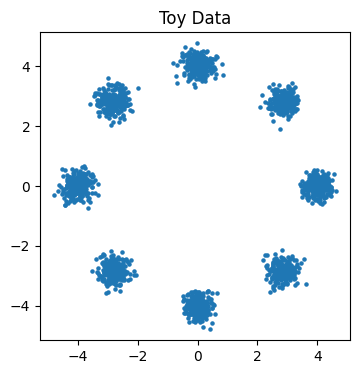

In [3]:
def sample_data(n):
    K = 8
    k = torch.randint(0, K, (n,), device=device)
    theta = 2 * math.pi * k.float() / K
    centers = torch.stack([4*torch.cos(theta), 4*torch.sin(theta)], dim=1)
    return centers + 0.25*torch.randn(n, 2, device=device)

# Quick visualisation
x_vis = sample_data(2000).cpu().numpy()
plt.figure(figsize=(4,4))
plt.scatter(x_vis[:,0], x_vis[:,1], s=5)
plt.axis('equal'); plt.title('Toy Data'); plt.show()


### Diffusion Schedule

We define a **linear $\beta_t$** schedule between $ 10^{-4} $ and $ 0.02 $.  

The **forward process** is a fixed Gaussian noising process:

$$
q(x_t \mid x_0) = \mathcal{N} \bigl( \sqrt{\bar{\alpha}_t}\, x_0,\; (1 - \bar{\alpha}_t) I \bigr),
$$

where

$$
\bar{\alpha}_t = \prod_{s=1}^t \alpha_s, \qquad \alpha_t = 1 - \beta_t.
$$

Intuitively, as $ t \to T $, the data is gradually diffused to a standard Gaussian distribution.


In [4]:
T = 1000  # number of diffusion steps
betas = torch.linspace(1e-4, 0.02, T, device=device)
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)  # cumulative product


# Score Model — Simple MLP

The model takes as input $(x_t, t)$ and predicts the added noise $\eta$.  
We concatenate normalized $t$ as an extra input feature.


In [5]:
class MLP(nn.Module):
    def __init__(self, dim=2, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim+1, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden, dim),
        )
    def forward(self, x, t):
        t = t.unsqueeze(-1)/T
        return self.net(torch.cat([x,t], dim=-1))

model = MLP().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)


### Training — Denoising Score Matching

For each training step:
1. Sample $ x_0 \sim p_{\mathrm{data}} $  
2. Sample $ t \sim \{1, \dots, T\} $ 
3. Sample noise $ \varepsilon \sim \mathcal{N}(0, I) $  
4. Form the noisy data
   $$
   x_t = \sqrt{\bar{\alpha}_t}\, x_0 + \sqrt{1 - \bar{\alpha}_t}\, \varepsilon
   $$
5. Train the network to predict $\varepsilon$ from $(x_t, t)$:

$$
\mathcal{L}(\theta) 
= \mathbb{E}_{x_0, t, \varepsilon} 
\Big[ \big\| \varepsilon - \varepsilon_\theta(x_t, t) \big\|^2 \Big].
$$

This is the standard **noise-prediction loss** used in DDPMs.


In [6]:
def train(steps=20000, batch=4096):
    for step in range(steps):
        x0 = sample_data(batch)
        t = torch.randint(0, T, (batch,), device=device)
        eps = torch.randn_like(x0)

        alpha_bar_t = alpha_bars[t].unsqueeze(-1)
        xt = torch.sqrt(alpha_bar_t)*x0 + torch.sqrt(1 - alpha_bar_t)*eps

        eps_pred = model(xt, t.float())
        loss = F.mse_loss(eps_pred, eps)

        opt.zero_grad()
        loss.backward()
        opt.step()

        if step % 1000 == 0:
            print(f"[{step}] loss={loss.item():.4f}")


### Sampling — Reverse Diffusion

Sampling starts from pure Gaussian noise $ x_T \sim \mathcal{N}(0, I) $, and iteratively applies the **reverse SDE** using Euler steps:

$$
x_{t-1} 
= \frac{1}{\sqrt{\alpha_t}} 
\left( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}}\, \varepsilon_\theta(x_t, t) \right)
+ \sqrt{\beta_t}\, z,
$$

where $ z \sim \mathcal{N}(0, I) $ and $ t = T, \dots, 1 $.

This gradually denoises the sample, reversing the forward noising process to obtain a draw from \( p_\theta(x_0) \).


In [7]:
@torch.no_grad()
def sample(n=2000):
    x = torch.randn(n, 2, device=device)
    for t in reversed(range(T)):
        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]

        z = torch.randn_like(x) if t > 0 else 0
        t_vec = torch.full((n,), t, device=device).float()
        eps_theta = model(x, t_vec)

        x = (1/torch.sqrt(alpha_t)) * (
            x - (1 - alpha_t)/torch.sqrt(1 - alpha_bar_t)*eps_theta
        ) + torch.sqrt(beta_t)*z
    return x.cpu()


### Run Training & Visualise

We train the diffusion model for 10,000 steps and then generate samples.

The generated distribution should converge to the **8-cluster ring structure**, demonstrating that the diffusion model has learned the target density.


[0] loss=0.9804
[1000] loss=0.3035
[2000] loss=0.3309
[3000] loss=0.3035
[4000] loss=0.3021
[5000] loss=0.3075
[6000] loss=0.2932
[7000] loss=0.3054
[8000] loss=0.2894
[9000] loss=0.3070


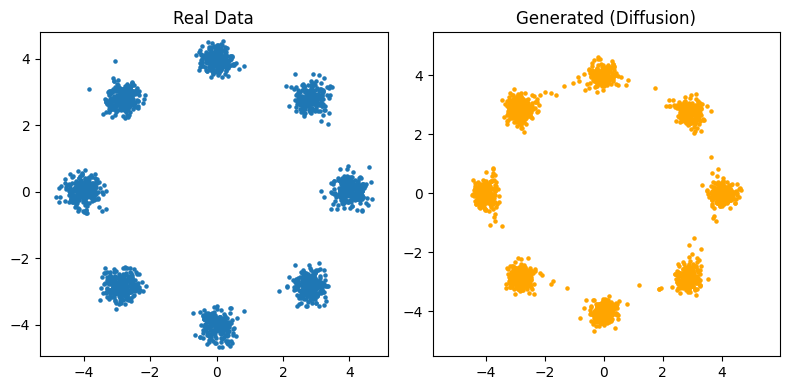

In [8]:
train(steps=10000)

samples = sample(2000).numpy()
real = sample_data(2000).cpu().numpy()

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(real[:,0], real[:,1], s=5)
plt.axis('equal'); plt.title("Real Data")

plt.subplot(1,2,2)
plt.scatter(samples[:,0], samples[:,1], s=5, c='orange')
plt.axis('equal'); plt.title("Generated (Diffusion)")
plt.tight_layout()
plt.show()
